### Introduction

This is my first Data Science challenge and although there are many great notebooks that allow you to reach very high scores (83% or higher) I tried to develop my own workflow, picking advices from the discussion forum and implementing some meaningful steps to reach a decent score.

Among all the notebooks that I read, I found very useful:

-  [Zlatan Kremonic - Titanic Random Forest: 82.78%](https://www.kaggle.com/zlatankr/titanic-random-forest-82-78/notebook)

-  [Pedro Marcelino - Data analysis and feature extraction with Python](https://www.kaggle.com/pmarcelino/data-analysis-and-feature-extraction-with-python/notebook)

They both give a nice and smooth explanation especially about the exploratory analysis which is easy to follow even for a beginner like I am. Keep in mind that these are just 2 of the hundreds you can find in the forum and most of them are equally valuable. Comments and answers to notebooks are another rich source of knowledge that it is worth to spend some time on ([Chris Deotte](https://www.kaggle.com/cdeotte) is one of the most active in this sense).

With this notebook you will reach 0.81818 which is Top 5% at the time of writing by using simple Logistic Regression and little feature engineering. One of the key steps that allowed me to make a jump in the score was a correction in the dataset that I made when I grouped all the passengers by family, as you will see later down in the notebook.

Of course any comment or suggestion is more than welcome, thank you!

### Let's start!

First thing to do, as always, is importing all the libraries we are going to use.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import count
from IPython.display import display, Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Next, we join train and test dataframes in order to do all the processing (filling, cleaning, engineering) all at once. We will then separate them again at the end of the process by using the <b><i>Survived</i></b> column.

In [2]:
dset = pd.concat([pd.read_csv('dataset/train.csv'), pd.read_csv('dataset/test.csv')], sort=False)
dset.reset_index(inplace=True, drop=True)
display(dset.head())
print('\nNumber of instances:\n')
print('\tTrain: {}'.format(len(dset[np.isfinite(dset['Survived'])])))
print('\tTest: {}'.format(len(dset[dset['Survived'].isnull()])))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Number of instances:

	Train: 891
	Test: 418


By looking at the information given we can already try to guess which feature is likely to play an important role in this classification problem (<b><i>Pclass</i></b>, <b><i>Sex</i></b> and <b><i>Age</i></b> are the most obvious ones) and which not (<b><i>PassengerId</i></b> and <b><i>Embarked</i></b>).

In order to have a first contact with the data, let's plot the survival rate of the three categories (women, children, men) divided by class. To do that, we temporarily create a copy of the data and modify its <b><i>Sex</i></b> column. We choose 14.5 as the maximum age classifying a child, later we will see why.

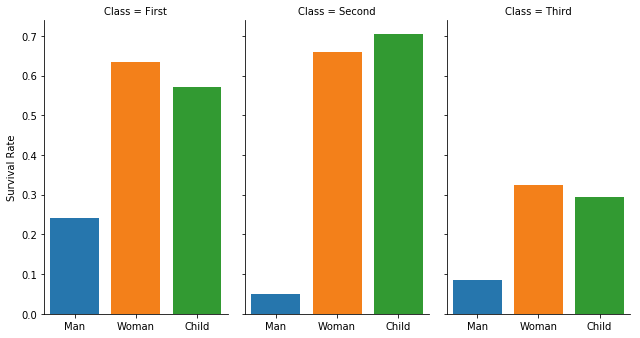

In [3]:
temp = dset.copy()
temp['Sex'] = np.where(temp['Age'] <= 14.5, 'Child', np.where(temp['Sex'] == 'female', 'Woman', 'Man'))
temp['Pclass'] = temp['Pclass'].map({1: 'First', 2: 'Second', 3: 'Third'})

df_survival_rate = pd.DataFrame({'Category': ['Man', 'Woman', 'Child'] * 3,
                                 'Class': ['First'] * 3 + ['Second'] * 3 + ['Third'] * 3,
                                 'Rate': [0] * 9})

for i in range(len(df_survival_rate)):
    cat, pclass = df_survival_rate.loc[i, ['Category', 'Class']]
    
    sub_df = temp[(temp['Sex'] == cat) & (temp['Pclass'] == pclass)]
    sub_df_alive = sub_df[sub_df['Survived'] == 1]
    
    df_survival_rate.loc[i, 'Rate'] = len(sub_df_alive) / len(sub_df)

f = sns.catplot('Category', 'Rate', col='Class', data=df_survival_rate, saturation=.9,
                   kind='bar', ci=None, aspect=.6)
_ = f.set_axis_labels('', 'Survival Rate')

del temp

It was a pretty easy guess but now it is confirmed: women and children had an advantage over men as well as 1st and 2nd class passengers had over the ones belonging to 3rd.

<b><i>PassengerId</i></b> is just a number assigned to each passenger with no criteria so we can safely drop it.

In [4]:
dset.drop('PassengerId', axis=1, inplace=True)

Now it's time to analyze the missing values and try to fill them properly.

In [5]:
def count_nan():
    
    df = []

    for col in dset:
        nan = dset[dset[col].isnull()]
        if len(nan):
            perc = round(len(nan) / len(dset), 3) * 100
            df.append((col, len(nan), perc))
    
    df.sort(key=lambda x: x[2], reverse=True)
    df = pd.DataFrame(df, index=[el[0] for el in df], columns=[0, 'Missing', '%']).drop(0, axis=1)
    
    display(df)

count_nan()

,Missing,%
Cabin,1014,77.5
Survived,418,31.9
Age,263,20.1
Embarked,2,0.2
Fare,1,0.1


As we can see there are 5 columns containing at least 1 missing value, let's make some considerations:

-  <b><i>Cabin</i></b>: by intuition I would probably think that this feature might be important for the prediction task. For example, it is not absurd to think that the lifeboats area was easier to reach from some cabins compared to other ones due to the mess going on right after the collision. Problem is that 77.5 % of missing values is too much to try to fill. It is safer to just drop the entire column.
<br><br>
-  <b><i>Survived</i></b>: obviously we do not care about this one, those NaN are coming from the test set that we joined previously.
<br><br>
-  <b><i>Age</i></b>: 20.1 % is still a considerable amount of missing values but this feature as we saw before is too important to be dropped, so we will see later how to fill it.
<br><br>
-  <b><i>Embarked</i></b>: just 2 values here, we can fill it with the most common entry.
<br><br>
-  <b><i>Fare</i></b>: the only missing value will be filled by the mean value of the column.

Let's start by dropping <b><i>Cabin</i></b> and filling <b><i>Embarked</i></b> and <b><i>Fare</i></b>.

In [6]:
dset.drop('Cabin', axis=1, inplace=True)
dset.loc[dset['Fare'].isnull(), 'Fare'] = dset['Fare'].mean()
dset.loc[dset['Embarked'].isnull(), 'Embarked'] = dset['Embarked'].value_counts().index[0]

count_nan()

,Missing,%
Survived,418,31.9
Age,263,20.1


To handle the <b><i>Age</i></b> problem, we first extract 2 new features from <b><i>Name</i></b>: <b><i>Surname</i></b> and <b><i>Title</i></b>.

In [7]:
dset = pd.concat([dset, dset['Name'].str.extract(r'(?P<Surname>\w+[-]?\w+),\s(?P<Title>\w+)')],
                 axis=1).drop('Name', axis=1)    

dset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Surname,Title
0,0.0,3,male,22.0,1,0,A/5 21171,7.2500,S,Braund,Mr
1,1.0,1,female,38.0,1,0,PC 17599,71.2833,C,Cumings,Mrs
2,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Heikkinen,Miss
3,1.0,1,female,35.0,1,0,113803,53.1000,S,Futrelle,Mrs
4,0.0,3,male,35.0,0,0,373450,8.0500,S,Allen,Mr


Now we can fill each NaN in <b><i>Age</i></b> with the mean value of the corresponding Title.

In [8]:
info = dset.groupby('Title').describe()['Age']['mean'].sort_values(ascending=False)
display(info)
dset.loc[dset['Age'].isnull(), 'Age'] = dset.loc[dset['Age'].isnull(), 'Title'].map(info)

count_nan()

Title
Capt        70.000000
Col         54.000000
Sir         49.000000
Major       48.500000
Lady        48.000000
Dr          43.571429
Rev         41.250000
Don         40.000000
Dona        39.000000
Jonkheer    38.000000
Mrs         36.994118
the         33.000000
Mr          32.252151
Ms          28.000000
Mlle        24.000000
Mme         24.000000
Miss        21.774238
Master       5.482642
Name: mean, dtype: float64

,Missing,%
Survived,418,31.9


Now that the complete dataset is free from missing values it is time to have a first look at the correlation between our target (<b><i>Survived</i></b>) and the rest of the features. To do that we check the correlation matrix which, in our case, is a matrix containing the [Pearson Correlation Coefficient (PCC)](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between all the features involved. In short, PCC has value between -1 and 1 and gives an indication on how much 2 variables are linearly correlated. The higher the value (absolute value) the stronger the linear correlation (positive or negative) between the variables. Value of 0 or in general close to 0 means there is no or very low correlation.

I wrote a small function to display a correlation matrix containing all the features whose PCC with the target variable is higher than a threshold. At this step we set this threshold to be 0 in order to show all the features, later we are going to use different values. It is important to stress the point that when we talk about PCC value we mean ABSOLUTE VALUE.

The only thing we do before creating the correlation matrix is to transform <b><i>Sex</i></b> into a numerical feature, assigning the value of 1 for female and 0 for male.

In [9]:
def create_corr_mat(df, th):
    
    df2 = df.copy()

    corr_mat = df2.corr().nlargest(500, 'Survived')
    corr_mat = corr_mat[corr_mat.index]

    corr_mat = corr_mat[abs(corr_mat['Survived']) > th]
    corr_mat = corr_mat[corr_mat.index]

    return corr_mat

dset['Sex'] = np.where(dset['Sex'] == 'female', 1, 0)
create_corr_mat(dset, 0)

,Survived,Sex,Fare,Parch,SibSp,Age,Pclass
Survived,1.000000,0.543351,0.257307,0.081629,-0.035322,-0.087092,-0.338481
Sex,0.543351,1.000000,0.185484,0.213125,0.109609,-0.082965,-0.124617
Fare,0.257307,0.185484,1.000000,0.221522,0.160224,0.169876,-0.558477
Parch,0.081629,0.213125,0.221522,1.000000,0.373587,-0.138532,0.018322
SibSp,-0.035322,0.109609,0.160224,0.373587,1.000000,-0.220784,0.060832
Age,-0.087092,-0.082965,0.169876,-0.138532,-0.220784,1.000000,-0.377708
Pclass,-0.338481,-0.124617,-0.558477,0.018322,0.060832,-0.377708,1.000000


Focusing only on the target feature (<b><i>Survived</i></b>), there are few aspects that are worth to be discussed:

-  It has a strong POSITIVE linear correlation with the feature <b><i>Sex</i></b>. Not surprising at all: women survive more than men.


-  It has a POSITIVE linear correlation with the feature <b><i>Fare</i></b>. It means that the higher the Fare the higher the chances of survival. This makes sense because, as a general rule, the most expensive tickets are bought by rich people who belong to the 1st/2nd class.


-  It has a NEGATIVE linear correlation with the feature <b><i>Pclass</i></b>. Remember: here classes are represented as integers (1, 2, 3) and the PCC being negative is simply telling us that the higher the class (the integer, not from a social point of view) the lower the chances of survival, which of course makes sense and is consistent with the "survival rate vs class" plot I have shown at the beginning. But we can go ahead in the analysis: that plot also shows us that there is NOT obvious difference between 1st and 2nd class passengers. Biggest gap is between children's survival rate but it's not correlated with the concept of class itself since it's much higher for 2nd class children. I thought that this aspect might be misleading for the algorithm and decided to transform <b><i>Pclass</i></b> into a categorical feature, as we will see later.


-  It does NOT show any evident linear correlation with <b><i>Parch</i></b>, <b><i>SibSp</i></b> and <b><i>Age</i></b>. Regarding the first two, as many of you have already said, it is often good practice to combine feature that individually have PCC close to 0 and try to create a new feature with higher PCC. We will do this by creating the feature called "FamSize".


-  The apparently random relation betweeen <b><i>Survived</i></b> and <b><i>Age</i></b> might look weird but it actually makes more sense after a deeper analysis. Thinking carefully about the problem, during those confused moments right after hitting the iceberg nobody was really caring about the actual age of the passengers. The only important thing was whether the passenger was a child or not. For the rest, passengers of age 20, 30, 50 or whatever they were all treated in the same way (we are not interested here in passenger's sex or class). This is the reason why the PCC is failing at this specific task. In this new scenario, we need to slightly modify the feature <b><i>Age</i></b> and make it binary. That's all we are interested in: child or adult.

First step: make <b><i>Pclass</i></b> categorical. Solution is easy: map each integer with the corrisponding ordinal value.

In [10]:
dset['Pclass'] = dset['Pclass'].map({1: 'First', 2: 'Second', 3: 'Third'})

Second step: make <b><i>Age</i></b> binary. We need to choose an age to separate children from adults. To do that, we take the maximum age of all the children in the dataset (by considering the title <i>Master</i>) and use that as threshold: all passengers younger than that will be children (Age = 1), the others will be adults (Age = 0). Maximum age for <i>Master</i> turns out to be 14.5.

In [11]:
child_max = dset.groupby('Title').describe().loc['Master']['Age', 'max']
dset['Age'] = np.where(dset['Age'] <= child_max, 1, 0)

dset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Surname,Title
0,0.0,Third,0,0,1,0,A/5 21171,7.2500,S,Braund,Mr
1,1.0,First,1,0,1,0,PC 17599,71.2833,C,Cumings,Mrs
2,1.0,Third,1,0,0,0,STON/O2. 3101282,7.9250,S,Heikkinen,Miss
3,1.0,First,1,0,1,0,113803,53.1000,S,Futrelle,Mrs
4,0.0,Third,0,0,0,0,373450,8.0500,S,Allen,Mr


Binarization of <b><i>Age</i></b> allows us to check for potential errors in the feature <b><i>Title</i></b>.

In fact, there are only 2 categories which can have <b><i>Age</i></b> = 1:

-  <i>Master</i>: 100% of them must be child

-  <i>Miss</i>: a certain amount of them must be child but not 100% because unmarried adult women also fall inside this category.


To check whether our dataset is correct

In [12]:
dset['Age'].groupby(dset['Title']).mean()

Title
Capt        0.000000
Col         0.000000
Don         0.000000
Dona        0.000000
Dr          0.000000
Jonkheer    0.000000
Lady        0.000000
Major       0.000000
Master      1.000000
Miss        0.192308
Mlle        0.000000
Mme         0.000000
Mr          0.006605
Mrs         0.005076
Ms          0.000000
Rev         0.000000
Sir         0.000000
the         0.000000
Name: Age, dtype: float64

As expected, there are some errors. In this series, a value of 0 means no child for that specific Title while a value of 1 means that all the instances of that Title are children.

Looking carefully we see that almost all the categories are correct because their values are all 0, they don't contain children instances and they don't have to. <i>Master</i> and <i>Miss</i> are also correct because as we said before:

-  100% of <i>Master</i> instances must be child...and they are


-  a certain amount (but not 100%) of <i>Miss</i> instances must be child...and they are


The problem appears with <i>Mr</i> and <i>Mrs</i> which should both be 0 (they must have no children) but are instead > 0.

This means that there is some young boy wrongly assigned as <i>Mr</i> and some young girl wrongly assigned as <i>Mrs</i>.

Correction is easy to do

In [13]:
dset.loc[(dset['Sex'] == 0) & (dset['Age'] == 1), 'Title'] = 'Master'
dset.loc[(dset['Sex'] == 1) & (dset['Age'] == 1), 'Title'] = 'Miss'

dset['Age'].groupby(dset['Title']).mean()

Title
Capt        0.000000
Col         0.000000
Don         0.000000
Dona        0.000000
Dr          0.000000
Jonkheer    0.000000
Lady        0.000000
Major       0.000000
Master      1.000000
Miss        0.195402
Mlle        0.000000
Mme         0.000000
Mr          0.000000
Mrs         0.000000
Ms          0.000000
Rev         0.000000
Sir         0.000000
the         0.000000
Name: Age, dtype: float64

Good, now all the children are where they have to be.


Next we create the <b><i>FamSize</i></b> feature and drop <b><i>SibSp</i></b> and <b><i>Parch</i></b>.

In [14]:
dset['FamSize'] = dset['SibSp'] + dset['Parch'] + 1
dset.drop(['SibSp', 'Parch'], axis=1, inplace=True)

create_corr_mat(dset, 0)

,Survived,Sex,Fare,Age,FamSize
Survived,1.000000,0.543351,0.257307,0.123947,0.016639
Sex,0.543351,1.000000,0.185484,0.052280,0.188583
Fare,0.257307,0.185484,1.000000,-0.006153,0.226465
Age,0.123947,0.052280,-0.006153,1.000000,0.427256
FamSize,0.016639,0.188583,0.226465,0.427256,1.000000


So apparently <b><i>FamSize</i></b> has a lower PCC than both <b><i>SibSp</i></b> and <b><i>Parch</i></b>: we made things worse! No problem, we still need to manipulate <b><i>FamSize</i></b> a little bit.

Another thing to notice is how <b><i>Age</i></b>'s PCC increased after making it binary. That's what we wanted and expected.

Since later we will want to group passengers by family, let's introduce a new feature called <b><i>FamCode</i></b> which is just an identifier of a certain family. All passengers belonging to the same family must have equal <b><i>FamCode</i></b> identifier.

To isolate families, we first group passengers by <b><i>Ticket</i></b> and <b><i>Surname</i></b> and then assign the code

In [15]:
c = count(1)

dset['FamCode'] = 0
families = dset.groupby(['Ticket', 'Surname'])
for i, f in families:
    dset.loc[f.index, 'FamCode'] = next(c)

dset.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Surname,Title,FamSize,FamCode
0,0.0,Third,0,0,A/5 21171,7.2500,S,Braund,Mr,2,779
1,1.0,First,1,0,PC 17599,71.2833,C,Cumings,Mrs,2,895
2,1.0,Third,1,0,STON/O2. 3101282,7.9250,S,Heikkinen,Miss,1,1010
3,1.0,First,1,0,113803,53.1000,S,Futrelle,Mrs,2,78
4,0.0,Third,0,0,373450,8.0500,S,Allen,Mr,1,705


Cool! Now we know which passenger belongs to which family.

<b>WRONG</b>! There is a problem, as always. Let's have a closer look at the code below and see what it's doing. The goal is to find errors in the assignment of the <b><i>FamCode</i></b> we just did. To do that we are basically saying:

1. Consider only the passengers with AT LEAST 1 more person in the family and group them by <b><i>FamCode</i></b>. This means considering all those passengers who have <b><i>FamSize</i></b> > 1.


2. Good! Now take the family and check its length. If the <b><i>FamCode</i></b> assignment is done the right way there MUST be NO family with length equal to 1 because don't forget point 1 in this list: we want only the passengers with <b><i>FamSize</i></b> > 1.


3. Now my dear little code, if you find (and you shouldn't!) any family with just one person please show it to me so I can check what is wrong with it.


4. To avoid very long outputs just show me the first 3 errors, for the rest just keep counting them


5. Thanks!

In [16]:
counter = 0
for i, f in dset[dset['FamSize'] > 1].groupby('FamCode'):
    if len(f) == 1 and counter < 3:
        display(f)
        counter += 1
    elif len(f) == 1 and counter >= 3:
        counter += 1
        
print('\nThere are {} instances that need to be corrected.'.format(counter))

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Surname,Title,FamSize,FamCode
1196,NaN,First,1,0,112901,26.55,S,Crosby,Mrs,3,30


,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Surname,Title,FamSize,FamCode
356,1.0,First,1,0,113505,55.0,S,Bowerman,Miss,2,45


,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Surname,Title,FamSize,FamCode
166,1.0,First,1,0,113505,55.0,S,Chibnall,Mrs,2,46



There are 70 instances that need to be corrected.


And there you go...70 mistakes. Not nice.

What's up with <i>Mrs Crosby</i>? Her family has 3 members but she's the only one with <b><i>FamCode</i></b> = 30? Where is the trick?

Let me quickly check one thing

In [17]:
dset[dset['Surname'] == 'Crosby']

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Surname,Title,FamSize,FamCode
540,1.0,First,1,0,WE/P 5735,71.00,S,Crosby,Miss,3,1024
745,0.0,First,0,0,WE/P 5735,71.00,S,Crosby,Capt,3,1024
1196,NaN,First,1,0,112901,26.55,S,Crosby,Mrs,3,30


Oh, OK now I see the trick: for some reason <i>Mrs Crosby</i> bought a different ticket from the one her husband and daughter did, that's why I missed her before.

Just make this simple correction and we are good to go

In [18]:
dset.loc[1196, 'FamCode'] = 1024
dset[dset['Surname'] == 'Crosby']

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Surname,Title,FamSize,FamCode
540,1.0,First,1,0,WE/P 5735,71.00,S,Crosby,Miss,3,1024
745,0.0,First,0,0,WE/P 5735,71.00,S,Crosby,Capt,3,1024
1196,NaN,First,1,0,112901,26.55,S,Crosby,Mrs,3,1024


And what about <i>Mrs Chibnall</i> and <i>Miss Bowerman</i>? Well in this case they are mother and daughter with same ticket but different surname.

Let's fix this one too

In [19]:
dset.loc[356, 'FamCode'] = 46
dset[dset['Ticket'] == '113505']

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Surname,Title,FamSize,FamCode
166,1.0,First,1,0,113505,55.0,S,Chibnall,Mrs,2,46
356,1.0,First,1,0,113505,55.0,S,Bowerman,Miss,2,46


If you keep analyzing all the 70 mistakes you will see that they are just more examples of the same situations: either they have different ticket for some reason or differnt surname.

By googling the passengers involved you would be able to keep track of their actual families and correct the mistakes one by one.<br></br>Good news: I did that for you.

Run the code below to reassign the right <b><i>FamCode</i></b> to the right passenger

In [20]:
families = {'0': 484, '68': 509, '104': 382, '113': 731, '136': 83, '145': 825, '175': 615, '192': 607, '267': 486,
            '352': 317, '356': 46, '371': 378, '392': 382, '417': 268, '442': 753, '451': 738, '496': 682, '529': 369,
            '532': 317, '539': 119, '556': 871, '593': 648, '627': 113, '689': 229, '704': 596, '765': 113,
            '880': 182, '892': 369, '909': 1008, '912': 733, '925': 112, '968': 91, '1012': 664, '1024': 279,
            '1041': 90, '1075': 927, '1078': 772, '1111': 959, '1129': 266, '1196': 1024, '1247': 91, '1261': 350,
            '1267': 413, '1295': 908}

for i in families:
    dset.loc[int(i), 'FamCode'] = families[i]

Perfect, one less problem to solve. Short note: sometimes it is very hard to follow the actual relation between passengers. I did my best to do it correctly but don't be surprised in case you find any mistake.

During the whole process of looking for the right family for each passenger I also saw that in some cases <b><i>SibSp</i></b> or <b><i>Parch</i></b> or both contain wrong values, which causes wrong <b><i>FamSize</i></b> values as a consequence.

To assign the correct value to <b><i>FamSize</i></b> run the code below

In [21]:
for i, f in dset.groupby('FamCode'):
    dset.loc[f.index, 'FamSize'] = len(f)

At this point we are ready to check the survival rate as a function of <b><i>FamSize</i></b>

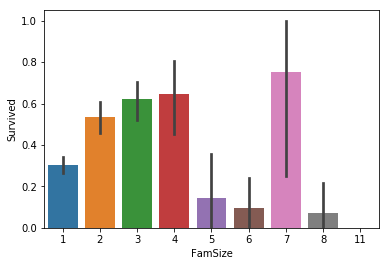

In [22]:
_ = sns.barplot(dset['FamSize'], dset['Survived'])

Well, we actually see a little trend here.

People with no family (<b><i>FamSize</i></b> = 1) have less chances to survive than the others, at least until <b><i>FamSize</i></b> = 4.

For <b><i>FamSize</i></b> > 4 the survival rate drops drastically (a part from <b><i>FamSize</i></b> = 7) and the uncertainty intervals are very large for some reason. Probably most of the big families come from the 3rd class and this cause the rate do be very low.

Based on this analysis, let's divide the feature <b><i>FamSize</i></b> into three categories:

-  <i>None</i>, <b><i>FamSize</i></b> = 1


- <i>Small</i>, 2 <= <b><i>FamSize</i></b> <= 4


- <i>Big</i>, <b><i>FamSize</i></b> > 4

In [23]:
dset['FamSize'] = np.where(dset['FamSize'] == 1, 'None', np.where(dset['FamSize'] <= 4, 'Small', 'Big'))

Remember that <b><i>FamSize</i></b>'s PCC was even lower than <b><i>SibSp</i></b>'s and <b><i>Parch</i></b>'s?

Check it now

In [24]:
temp = pd.get_dummies(dset, columns=['FamSize'])
display(create_corr_mat(temp, 0))

del temp

,Survived,Sex,FamSize_Small,Fare,Age,FamSize_Big,FamCode,FamSize_None
Survived,1.000000,0.543351,0.282498,0.257307,0.123947,-0.138411,-0.160256,-0.201376
Sex,0.543351,1.000000,0.262682,0.185484,0.052280,0.068965,-0.019370,-0.287558
FamSize_Small,0.282498,0.262682,1.000000,0.195444,0.185399,-0.181883,-0.079977,-0.880181
Fare,0.257307,0.185484,0.195444,1.000000,-0.006153,0.178740,-0.014547,-0.275460
Age,0.123947,0.052280,0.185399,-0.006153,1.000000,0.339674,0.018785,-0.343418
FamSize_Big,-0.138411,0.068965,-0.181883,0.178740,0.339674,1.000000,0.109664,-0.306631
FamCode,-0.160256,-0.019370,-0.079977,-0.014547,0.018785,0.109664,1.000000,0.024481
FamSize_None,-0.201376,-0.287558,-0.880181,-0.275460,-0.343418,-0.306631,0.024481,1.000000


Now the feature starts to gain importance, especially the categories <i>Small</i> and <i>None</i>. That should help the algorithm in making better predictions.

Now it is time to add the last new feature to our dataset. We'll call it <b><i>FamAlive</i></b> and it is the fraction of family members who survived:
<br></br><br></br><br></br>
$$FamAlive = \frac{members\quad of\quad the\quad family\quad who\quad survived}{members\quad of\quad the\quad family}$$

In [25]:
dset['FamAlive'] = 0
families = dset[dset['FamSize'] != 'None'].groupby(['FamCode'])

for i, f in families:

    fam_al = f[f['Survived'] == 1]
    dset.loc[f.index, 'FamAlive'] = len(fam_al) / len(f)
    
    
display(create_corr_mat(dset, 0))

,Survived,Sex,FamAlive,Fare,Age,FamCode
Survived,1.000000,0.543351,0.504993,0.257307,0.123947,-0.160256
Sex,0.543351,1.000000,0.270466,0.185484,0.052280,-0.019370
FamAlive,0.504993,0.270466,1.000000,0.244390,0.229148,-0.147454
Fare,0.257307,0.185484,0.244390,1.000000,-0.006153,-0.014547
Age,0.123947,0.052280,0.229148,-0.006153,1.000000,0.018785
FamCode,-0.160256,-0.019370,-0.147454,-0.014547,0.018785,1.000000


So the new feature has a strong correlation with the target...good, that's what we wanted.

Now we can finally create our final dataframe which will be used for the predictions.

To do that we need to choose which categorical features we want to use.

In [26]:
dset.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Surname,Title,FamSize,FamCode,FamAlive
0,0.0,Third,0,0,A/5 21171,7.2500,S,Braund,Mr,Small,484,0.0
1,1.0,First,1,0,PC 17599,71.2833,C,Cumings,Mrs,Small,895,0.5
2,1.0,Third,1,0,STON/O2. 3101282,7.9250,S,Heikkinen,Miss,None,1010,0.0
3,1.0,First,1,0,113803,53.1000,S,Futrelle,Mrs,Small,78,0.5
4,0.0,Third,0,0,373450,8.0500,S,Allen,Mr,None,705,0.0


-  <b><i>Ticket</i></b>: not needed, we used already its infomation.


-  <b><i>Embarked</i></b>: I would say it does not matter where passengers boarded Titanic but we'll keep it to be sure.


-  <b><i>Surname</i></b>: not needed, it was useful to extract family informations.


-  <b><i>Title</i></b>: this might be useful.


-  <b><i>FamSize</i></b>: we already saw it's an important feature.

Among numerical features, <b><i>FamCode</i></b> can also be removed because it's just an identifier assigned by us.

In [27]:
dset.drop(['Ticket', 'Surname', 'FamCode'], axis=1, inplace=True)

Now it's time to select the features (between all the dummies) that we actually want to use. This filter operation is done by selecting a threshold in the <i>create_corr_mat</i> function we created previously. For the moment we set it to be 0.1.

In [28]:
final_df = pd.get_dummies(dset)
corr_mat = create_corr_mat(final_df, 0.1)
corr_mat

,Survived,Sex,FamAlive,Title_Mrs,Title_Miss,Pclass_First,FamSize_Small,Fare,Embarked_C,Age,FamSize_Big,Embarked_S,FamSize_None,Pclass_Third,Title_Mr
Survived,1.000000,0.543351,0.504993,0.336074,0.329948,0.285904,0.282498,0.257307,0.168240,0.123947,-0.138411,-0.149683,-0.201376,-0.322308,-0.543225
Sex,0.543351,1.000000,0.270466,0.564419,0.671213,0.107371,0.262682,0.185484,0.066564,0.052280,0.068965,-0.115193,-0.287558,-0.116562,-0.863894
FamAlive,0.504993,0.270466,1.000000,0.304109,0.054273,0.224856,0.659618,0.244390,0.134890,0.229148,-0.033218,-0.057436,-0.622459,-0.270754,-0.323728
Title_Mrs,0.336074,0.564419,0.304109,1.000000,-0.209421,0.142214,0.377816,0.140937,0.092982,-0.131473,0.002902,-0.014738,-0.367117,-0.176866,-0.487598
Title_Miss,0.329948,0.671213,0.054273,-0.209421,1.000000,-0.019526,-0.014200,0.090133,-0.018122,0.185456,0.084388,-0.111130,-0.026988,0.033130,-0.579857
Pclass_First,0.285904,0.107371,0.224856,0.142214,-0.019526,1.000000,0.161283,0.599956,0.325722,-0.135838,-0.061731,-0.181800,-0.126321,-0.622172,-0.095184
FamSize_Small,0.282498,0.262682,0.659618,0.377816,-0.014200,0.161283,1.000000,0.195444,0.144720,0.185399,-0.181883,-0.046334,-0.880181,-0.223479,-0.299262
Fare,0.257307,0.185484,0.244390,0.140937,0.090133,0.599956,0.195444,1.000000,0.286241,-0.006153,0.178740,-0.169894,-0.275460,-0.419616,-0.192355
Embarked_C,0.168240,0.066564,0.134890,0.092982,-0.018122,0.325722,0.144720,0.286241,1.000000,0.005738,-0.088440,-0.778262,-0.097396,-0.171430,-0.065341
Age,0.123947,0.052280,0.229148,-0.131473,0.185456,-0.135838,0.185399,-0.006153,0.005738,1.000000,0.339674,0.029951,-0.343418,0.105488,-0.364029


As expected, female and male titles have high and low PCC, respectively. Differently from what I was expecting, <b><i>Embarked</i></b> actually shows some correlation with the target.

At this point we reduce the final df to have only those features we see above and print their number, for the sake of information.

In [29]:
final_df = final_df[corr_mat.index]
print('Number of features used: {}'.format(len(final_df.columns)))

Number of features used: 15


Now we can finally separate train and test set.

In [30]:
def get_sets(df):

    xtrain = df[np.isfinite(df['Survived'])].copy()
    ytrain = xtrain['Survived'].copy()
    xtrain.drop('Survived', axis=1, inplace=True)
    xtest = df[df['Survived'].isnull()].copy()
    xtest.drop('Survived', axis=1, inplace=True)
    xtest.reset_index(inplace=True, drop=True)
    
    cols = xtrain.columns
    scaler = MinMaxScaler()
    scaler.fit(xtrain)
    xtrain = pd.DataFrame(scaler.transform(xtrain), columns=cols)
    xtest = pd.DataFrame(scaler.transform(xtest), columns=cols)
    
    return xtrain, ytrain, xtest


X_train, y_train, X_test = get_sets(final_df)
print('Train set:')
display(X_train.head())
print('\n\nTest set:')
display(X_test.head())

Train set:


,Sex,FamAlive,Title_Mrs,Title_Miss,Pclass_First,FamSize_Small,Fare,Embarked_C,Age,FamSize_Big,Embarked_S,FamSize_None,Pclass_Third,Title_Mr
0,0.0,0.0,0.0,0.0,0.0,1.0,0.014151,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,1.0,0.5,1.0,0.0,1.0,1.0,0.139136,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.015469,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,1.0,0.5,1.0,0.0,1.0,1.0,0.103644,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.015713,0.0,0.0,0.0,1.0,1.0,1.0,1.0




Test set:


,Sex,FamAlive,Title_Mrs,Title_Miss,Pclass_First,FamSize_Small,Fare,Embarked_C,Age,FamSize_Big,Embarked_S,FamSize_None,Pclass_Third,Title_Mr
0,0.0,0.00,0.0,0.0,0.0,0.0,0.015282,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,1.0,0.25,1.0,0.0,0.0,1.0,0.013663,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.00,0.0,0.0,0.0,0.0,0.018909,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.00,0.0,0.0,0.0,0.0,0.016908,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,1.0,0.50,1.0,0.0,0.0,1.0,0.023984,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Next let's run a grid search for Logistic Regression and use the best model to make the predictions

{'C': 0.8, 'solver': 'newton-cg'}
Mean train score: 0.865
Mean test score: 0.859


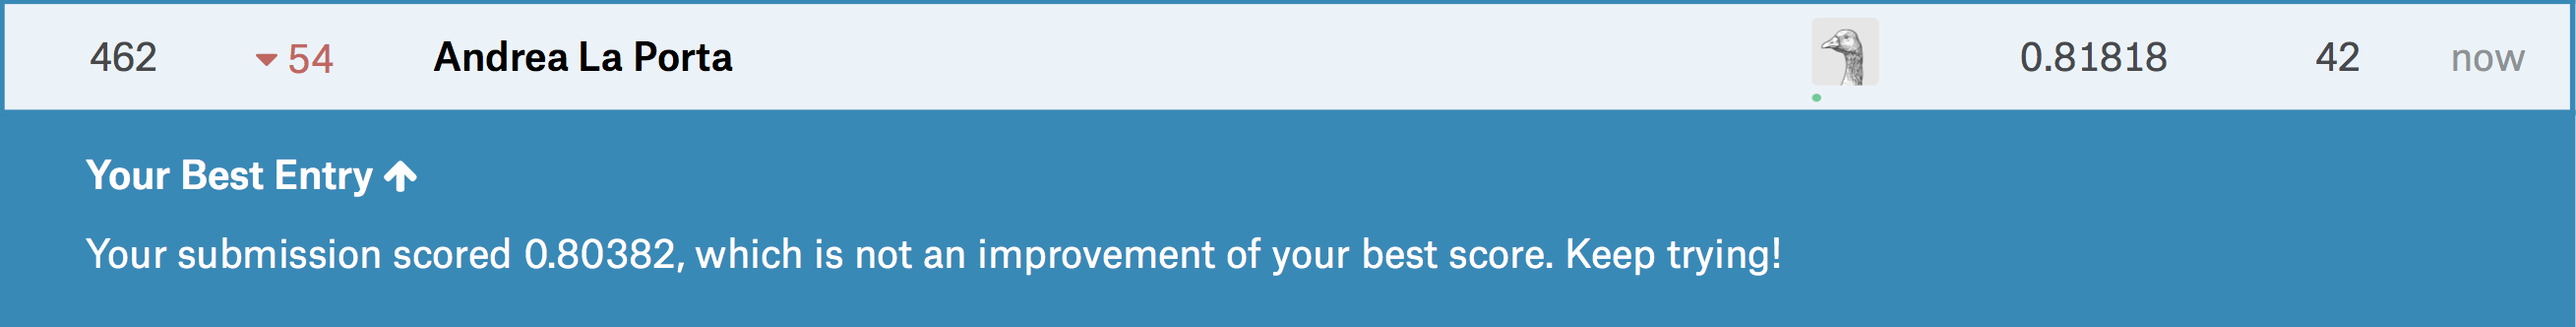

In [31]:
def run_grid_search():

    lr_values = {
                 'C': [i for i in np.arange(0.1, 1, 0.1)],
                 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
                 }

    lr = LogisticRegression(max_iter=1000)
    gs = GridSearchCV(lr, param_grid=lr_values, scoring='accuracy', return_train_score=True).fit(X_train, y_train)
    print(gs.best_params_)
    print('Mean train score: {}'.format(round(gs.cv_results_['mean_train_score'].mean(), 3)))
    print('Mean test score: {}'.format(round(gs.cv_results_['mean_test_score'].mean(), 3)))
    
    return gs.best_estimator_


best_model = run_grid_search()
preds = best_model.predict(X_test)

# To save the .csv file for submission
csv_to_submit = np.column_stack((range(892, 1310), preds))
np.savetxt('/Users/andrea/Desktop/titanic_preds.csv', csv_to_submit, delimiter=',', header='PassengerId,Survived',
           fmt='%i,%i', comments='')

Image(filename='screenshots/score1.png')

At this stage we are already able to reach more than 80% accuracy, which is a good result. Looking at the difference between the scores from GridSearch and the one from submission, I thought that maybe we are using too many features and this might cause overfitting.

So the next step consists in increasing the PCC threshold from 0.1 to 0.2. In this way we will only include those features whose PCC with the target is AT LEAST equal to 0.2.

Comparing with the previous correlation matrix we are basically excluding:

-  <b><i>Embarked_C</i></b>


-  <b><i>Age</i></b>


-  <b><i>FamSize_Big</i></b>


-  <b><i>Embarked_S</i></b>

,Survived,Sex,FamAlive,Title_Mrs,Title_Miss,Pclass_First,FamSize_Small,Fare,FamSize_None,Pclass_Third,Title_Mr
Survived,1.000000,0.543351,0.504993,0.336074,0.329948,0.285904,0.282498,0.257307,-0.201376,-0.322308,-0.543225
Sex,0.543351,1.000000,0.270466,0.564419,0.671213,0.107371,0.262682,0.185484,-0.287558,-0.116562,-0.863894
FamAlive,0.504993,0.270466,1.000000,0.304109,0.054273,0.224856,0.659618,0.244390,-0.622459,-0.270754,-0.323728
Title_Mrs,0.336074,0.564419,0.304109,1.000000,-0.209421,0.142214,0.377816,0.140937,-0.367117,-0.176866,-0.487598
Title_Miss,0.329948,0.671213,0.054273,-0.209421,1.000000,-0.019526,-0.014200,0.090133,-0.026988,0.033130,-0.579857
Pclass_First,0.285904,0.107371,0.224856,0.142214,-0.019526,1.000000,0.161283,0.599956,-0.126321,-0.622172,-0.095184
FamSize_Small,0.282498,0.262682,0.659618,0.377816,-0.014200,0.161283,1.000000,0.195444,-0.880181,-0.223479,-0.299262
Fare,0.257307,0.185484,0.244390,0.140937,0.090133,0.599956,0.195444,1.000000,-0.275460,-0.419616,-0.192355
FamSize_None,-0.201376,-0.287558,-0.622459,-0.367117,-0.026988,-0.126321,-0.880181,-0.275460,1.000000,0.138938,0.386747
Pclass_Third,-0.322308,-0.116562,-0.270754,-0.176866,0.033130,-0.622172,-0.223479,-0.419616,0.138938,1.000000,0.113778


Number of features used: 11
{'C': 0.8, 'solver': 'newton-cg'}
Mean train score: 0.862
Mean test score: 0.861


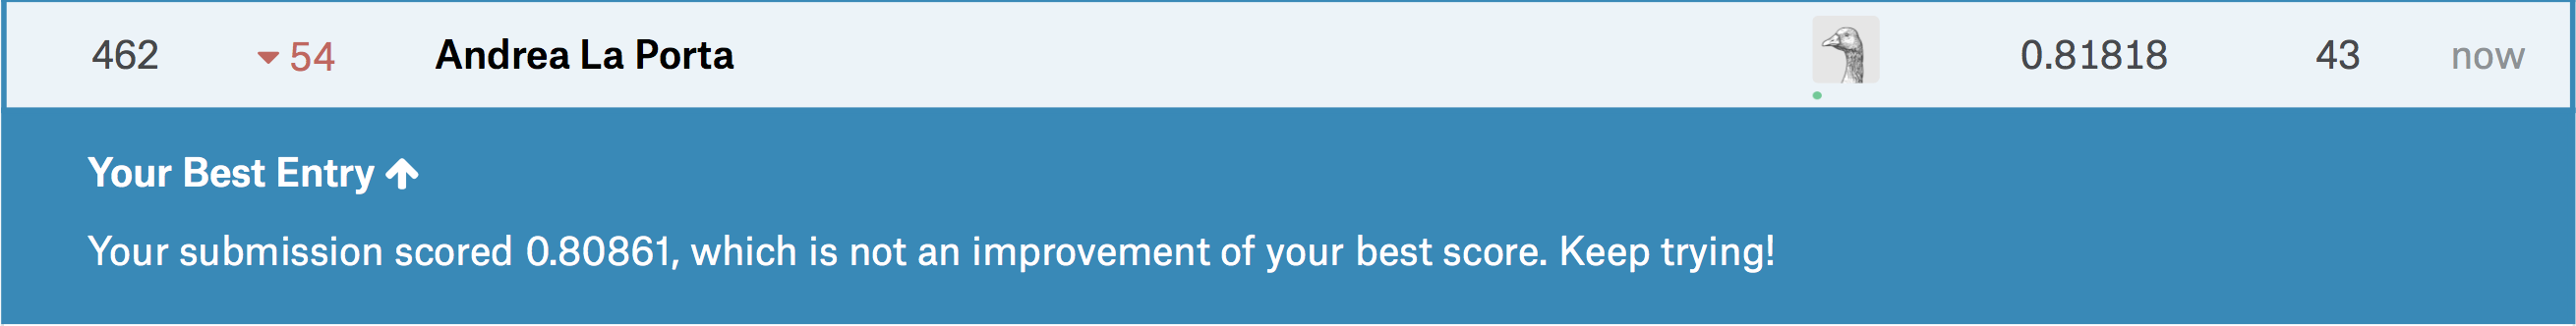

In [32]:
final_df = pd.get_dummies(dset)
corr_mat = create_corr_mat(final_df, 0.2)
display(corr_mat)
final_df = final_df[corr_mat.index]
print('Number of features used: {}'.format(len(final_df.columns)))
X_train, y_train, X_test = get_sets(final_df)

best_model = run_grid_search()
preds = best_model.predict(X_test)

csv_to_submit = np.column_stack((range(892, 1310), preds))
np.savetxt('/Users/andrea/Desktop/titanic_preds.csv', csv_to_submit, delimiter=',', header='PassengerId,Survived',
           fmt='%i,%i', comments='')

Image(filename='screenshots/score2.png')

Well it looks like before we were a little bit overfitting the dataset. Now the <i>Mean train score</i> is slighltly lower than before but the submission score increased from 80.4% to 80.9%.

But we are not done yet. It is true that increasing the threshold to 0.2 allowed us to reach higher precision but it is also true that not we are considering the feature <b><i>Age</i></b> anymore. Following the binarization we did earlier, we lost all the information about a passenger being an adult or a child. It is a big thing we are leaving out and we don't want that.

To solve the problem, let's create a new feature <b><i>Category</i></b>. This feature classifies the passengers as one of the following three categories: <i>Woman</i>, <i>Man</i> or <i>Child</i>.

In this way we are bringing back the information about the age, hoping that now it will have a PCC higher than 0.2.

,Survived,Sex,Category_Woman,FamAlive,Title_Mrs,Title_Miss,Pclass_First,FamSize_Small,Fare,FamSize_None,Pclass_Third,Title_Mr,Category_Man
Survived,1.000000,0.543351,0.516808,0.504993,0.336074,0.329948,0.285904,0.282498,0.257307,-0.201376,-0.322308,-0.543225,-0.560286
Sex,0.543351,1.000000,0.916381,0.270466,0.564419,0.671213,0.107371,0.262682,0.185484,-0.287558,-0.116562,-0.863894,-0.898533
Category_Woman,0.516808,0.916381,1.000000,0.200184,0.615921,0.522897,0.150790,0.202838,0.200304,-0.203945,-0.140953,-0.791656,-0.823398
FamAlive,0.504993,0.270466,0.200184,1.000000,0.304109,0.054273,0.224856,0.659618,0.244390,-0.622459,-0.270754,-0.323728,-0.322753
Title_Mrs,0.336074,0.564419,0.615921,0.304109,1.000000,-0.209421,0.142214,0.377816,0.140937,-0.367117,-0.176866,-0.487598,-0.507149
Title_Miss,0.329948,0.671213,0.522897,0.054273,-0.209421,1.000000,-0.019526,-0.014200,0.090133,-0.026988,0.033130,-0.579857,-0.603107
Pclass_First,0.285904,0.107371,0.150790,0.224856,0.142214,-0.019526,1.000000,0.161283,0.599956,-0.126321,-0.622172,-0.095184,-0.063955
FamSize_Small,0.282498,0.262682,0.202838,0.659618,0.377816,-0.014200,0.161283,1.000000,0.195444,-0.880181,-0.223479,-0.299262,-0.299855
Fare,0.257307,0.185484,0.200304,0.244390,0.140937,0.090133,0.599956,0.195444,1.000000,-0.275460,-0.419616,-0.192355,-0.186191
FamSize_None,-0.201376,-0.287558,-0.203945,-0.622459,-0.367117,-0.026988,-0.126321,-0.880181,-0.275460,1.000000,0.138938,0.386747,0.392689


Number of features used: 13

{'C': 0.30000000000000004, 'solver': 'newton-cg'}
Mean train score: 0.87
Mean test score: 0.868


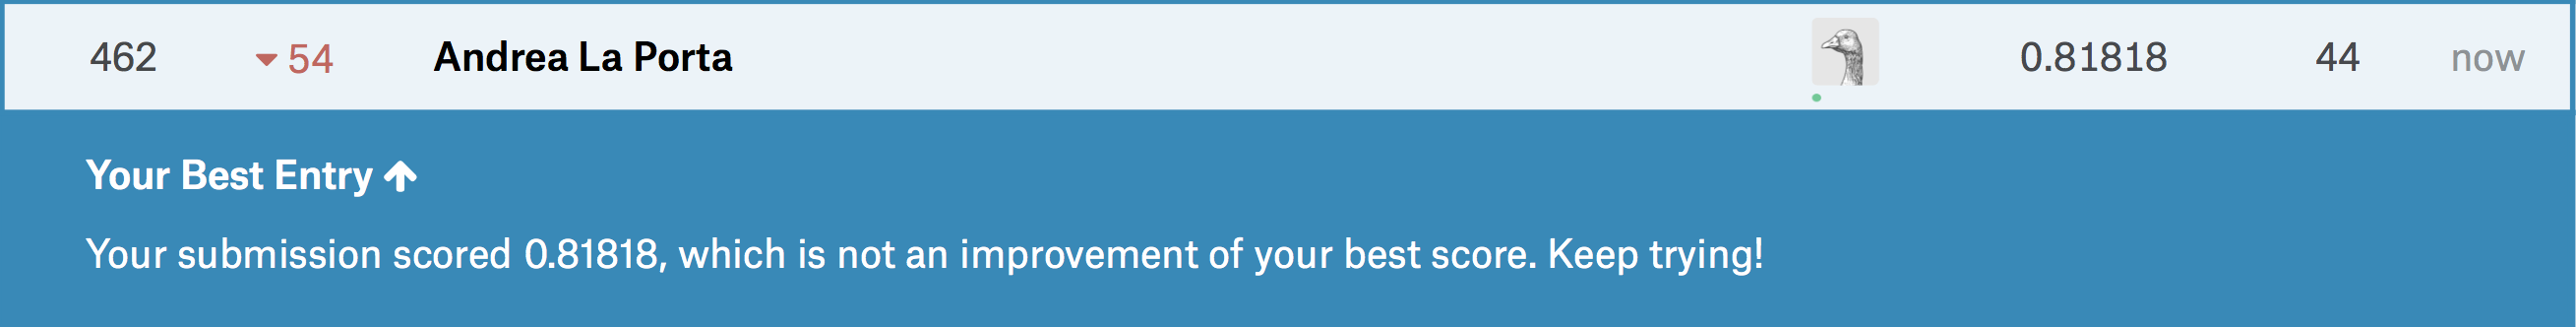

In [33]:
dset['Category'] = np.where(dset['Age'] == 1, 'Child', np.where(dset['Sex'] == 1, 'Woman', 'Man'))
final_df = pd.get_dummies(dset)
corr_mat = create_corr_mat(final_df, 0.2)
display(corr_mat)
final_df = final_df[corr_mat.index]
print('Number of features used: {}\n'.format(len(final_df.columns)))
X_train, y_train, X_test = get_sets(final_df)

best_model = run_grid_search()
preds = best_model.predict(X_test)

csv_to_submit = np.column_stack((range(892, 1310), preds))
np.savetxt('/Users/andrea/Desktop/titanic_preds.csv', csv_to_submit, delimiter=',', header='PassengerId,Survived',
           fmt='%i,%i', comments='')

Image(filename='screenshots/score3.png')

And it worked! Now <i>Category_Woman</i> and <i>Category_Man</i> have high PCC (> 0.5) and we are able to increase the score by almost 1%.